In [2]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from pandas import Series
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.stattools import adfuller
import investpy
import datetime as dt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima

In [3]:
#import data
df_MBB = pd.read_csv('MBB Historical Data.csv')


In [4]:
df_MBB

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2019,9276.7,9348.6,9444.5,9276.7,7400000,-0.51%
1,1/3/2019,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%
2,1/4/2019,8917.1,8821.2,9060.9,8653.4,12300000,0.54%
3,1/7/2019,9084.9,9108.9,9228.7,9060.9,8410000,1.88%
4,1/8/2019,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%
...,...,...,...,...,...,...,...
1068,4/13/2023,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%
1069,4/14/2023,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%
1070,4/17/2023,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%
1071,4/18/2023,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%


In [5]:
# Convert the 'date' column to a datetime data type
df_MBB['Date']=pd.to_datetime(df_MBB.Date,format='%m/%d/%Y')

2019-01-02     9276.7
2019-01-03     8869.2
2019-01-04     8917.1
2019-01-07     9084.9
2019-01-08     9037.0
               ...   
2023-04-13    18550.0
2023-04-14    18300.0
2023-04-17    18250.0
2023-04-18    18150.0
2023-04-19    18100.0
Name: Price, Length: 1073, dtype: float64

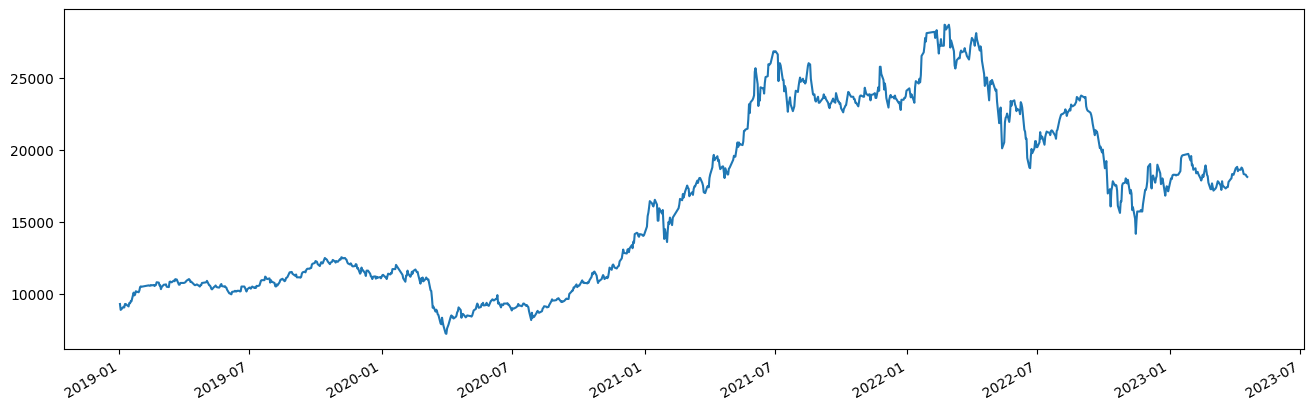

In [6]:
#set cột Date làm cột index
df_MBB=df_MBB.set_index(pd.DatetimeIndex(df_MBB['Date'].values))
df_MBB['Time'] = np.arange(len(df_MBB.index))
df_MBB['Price'].plot(figsize=(16,5))
df_MBB['Price']

In [7]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df_MBB['Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.327491
p-value                    0.616503
# lags used                0.000000
# observations          1072.000000
critical value (1%)       -3.436465
critical value (5%)       -2.864240
critical value (10%)      -2.568208
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


p-value > 0.05 nên tệp dữ liệu không có tính dừng

In [9]:
#Kiểm định sai phân bậc 1 của giá Close
df_MBB['d1'] = diff(df_MBB['Price'],k_diff=1)

In [10]:
adf_test(df_MBB['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -24.355411
p-value                    0.000000
# lags used                1.000000
# observations          1070.000000
critical value (1%)       -3.436476
critical value (5%)       -2.864245
critical value (10%)      -2.568210
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


p-value < 0.05 nên tệp dữ liệu có tính dừng

In [11]:
# Splitting the dataset into 70% training data and 30% testing data.
train_MBB, test_MBB = train_test_split(df_MBB['Price'], train_size=0.7, test_size=0.3,shuffle=False)

In [13]:
auto_arima(train_MBB,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  751
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5357.046
Date:                Mon, 24 Apr 2023   AIC                          10718.092
Time:                        21:03:45   BIC                          10727.332
Sample:                             0   HQIC                         10721.653
                                - 751                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.2421     11.215      1.716      0.086      -2.738      41.222
sigma2      9.367e+04   2252.570     41.586      0.000    8.93e+04    9.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):              1667.57
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              12.60   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model  = auto_arima(df_MBB['Price'],
                      test='adf',       # use adftest to find optimal 'd' # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)     # set to stepwise
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15749.359, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15751.317, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15751.313, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15747.878, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15751.792, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.902 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1073
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7872.939
Date:                Mon, 24 Apr 2023   AIC                          15747.878
Time:                        21:03:48   BIC                          15752.855
Sample:                             0   HQIC                         15749.764
          

In [15]:
df_USD = pd.read_csv('USD_VND Historical Data.csv')

In [16]:
df_USD['Date']=pd.to_datetime(df_USD.Date,format='%m/%d/%Y')

2019-01-02    23207.5
2019-01-03    23202.5
2019-01-04    23199.0
2019-01-07    23199.0
2019-01-08    23198.5
               ...   
2023-04-13    23440.0
2023-04-14    23440.0
2023-04-17    23485.0
2023-04-18    23505.0
2023-04-19    23511.0
Name: Price, Length: 1090, dtype: float64

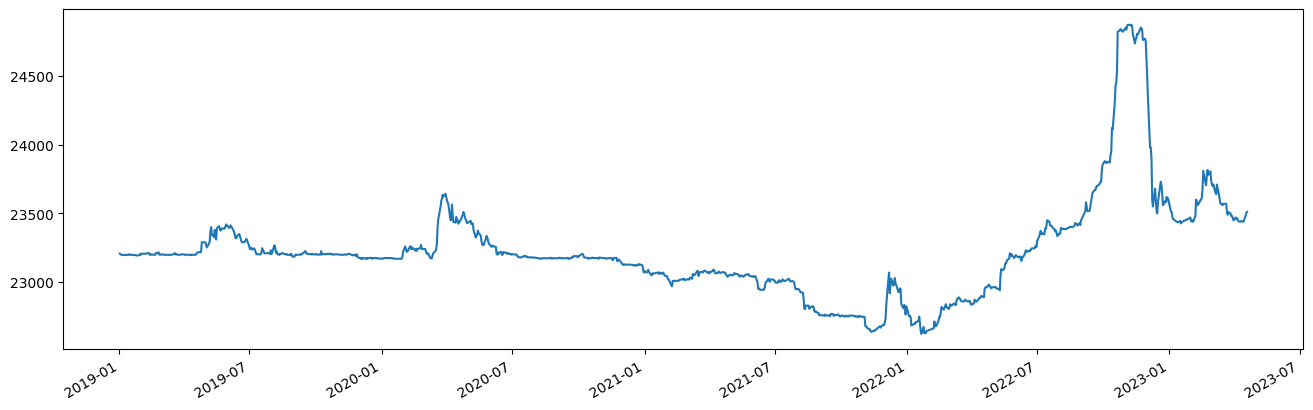

In [17]:
#set cột Date làm cột index
df_USD=df_USD.set_index(pd.DatetimeIndex(df_USD['Date'].values))
df_USD['Time'] = np.arange(len(df_USD.index))
df_USD['Price'].plot(figsize=(16,5))
df_USD['Price']

In [18]:
merged_df = pd.merge(df_MBB, df_USD, on='Date')

In [19]:
merged_df

,Date,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x,Time_x,d1,Price_y,Open_y,High_y,Low_y,Vol._y,Change %_y,Time_y
0,2019-01-02,9276.7,9348.6,9444.5,9276.7,7400000,-0.51%,0,NaN,23207.5,23194.5,23207.5,23192.5,20,0.05%,0
1,2019-01-03,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%,1,-407.5,23202.5,23204.5,23205.5,23192.5,20,-0.02%,1
2,2019-01-04,8917.1,8821.2,9060.9,8653.4,12300000,0.54%,2,47.9,23199.0,23199.0,23201.0,23193.0,20,-0.02%,2
3,2019-01-07,9084.9,9108.9,9228.7,9060.9,8410000,1.88%,3,167.8,23199.0,23197.0,23204.0,23191.0,20,0.00%,3
4,2019-01-08,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%,4,-47.9,23198.5,23199.5,23199.5,23190.5,20,0.00%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,2023-04-13,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%,1068,-150.0,23440.0,23447.0,23453.5,23440.0,20,-0.01%,1085
1069,2023-04-14,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%,1069,-250.0,23440.0,23445.5,23451.0,23442.5,10,0.00%,1086
1070,2023-04-17,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%,1070,-50.0,23485.0,23455.0,23495.0,23446.5,30,0.19%,1087
1071,2023-04-18,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%,1071,-100.0,23505.0,23510.0,23517.0,23472.5,20,0.09%,1088


In [20]:
result_USD = merged_df.dropna(subset=['Date'])

In [21]:
result_USD

,Date,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x,Time_x,d1,Price_y,Open_y,High_y,Low_y,Vol._y,Change %_y,Time_y
0,2019-01-02,9276.7,9348.6,9444.5,9276.7,7400000,-0.51%,0,NaN,23207.5,23194.5,23207.5,23192.5,20,0.05%,0
1,2019-01-03,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%,1,-407.5,23202.5,23204.5,23205.5,23192.5,20,-0.02%,1
2,2019-01-04,8917.1,8821.2,9060.9,8653.4,12300000,0.54%,2,47.9,23199.0,23199.0,23201.0,23193.0,20,-0.02%,2
3,2019-01-07,9084.9,9108.9,9228.7,9060.9,8410000,1.88%,3,167.8,23199.0,23197.0,23204.0,23191.0,20,0.00%,3
4,2019-01-08,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%,4,-47.9,23198.5,23199.5,23199.5,23190.5,20,0.00%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,2023-04-13,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%,1068,-150.0,23440.0,23447.0,23453.5,23440.0,20,-0.01%,1085
1069,2023-04-14,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%,1069,-250.0,23440.0,23445.5,23451.0,23442.5,10,0.00%,1086
1070,2023-04-17,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%,1070,-50.0,23485.0,23455.0,23495.0,23446.5,30,0.19%,1087
1071,2023-04-18,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%,1071,-100.0,23505.0,23510.0,23517.0,23472.5,20,0.09%,1088


In [22]:
df_USD=result_USD.drop(columns=['Price_x','Open_x','High_x','Low_x','Vol._x','Change %_x','Time_x','d1'])

2019-01-02    23207.5
2019-01-03    23202.5
2019-01-04    23199.0
2019-01-07    23199.0
2019-01-08    23198.5
               ...   
2023-04-13    23440.0
2023-04-14    23440.0
2023-04-17    23485.0
2023-04-18    23505.0
2023-04-19    23511.0
Name: Price_y, Length: 1073, dtype: float64

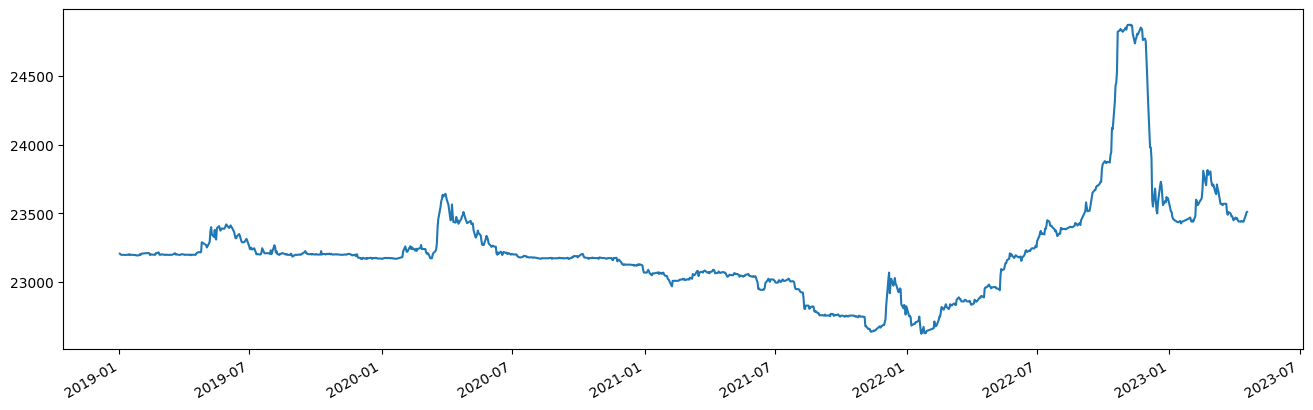

In [23]:
#set cột Date làm cột index
df_USD=df_USD.set_index(pd.DatetimeIndex(df_USD['Date'].values))
df_USD['Time'] = np.arange(len(df_USD.index))
df_USD['Price_y'].plot(figsize=(16,5))
df_USD['Price_y']

In [24]:
# Splitting the dataset into 70% training data and 30% testing data.
train_USD, test_USD = train_test_split(df_USD['Price_y'], test_size=.30, train_size=.70,shuffle=False)

2019-01-02    23207.5
2019-01-03    23202.5
2019-01-04    23199.0
2019-01-07    23199.0
2019-01-08    23198.5
               ...   
2023-04-13    23440.0
2023-04-14    23440.0
2023-04-17    23485.0
2023-04-18    23505.0
2023-04-19    23511.0
Name: Price_y, Length: 1073, dtype: float64

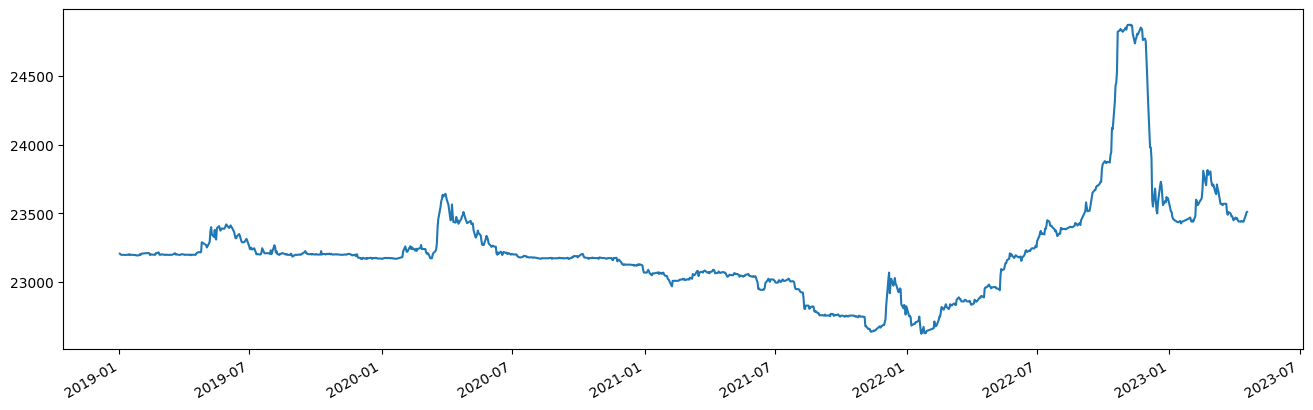

In [25]:
#set cột Date làm cột index
df_USD=df_USD.set_index(pd.DatetimeIndex(df_USD['Date'].values))
df_USD['Time'] = np.arange(len(df_USD.index))
df_USD['Price_y'].plot(figsize=(16,5))
df_USD['Price_y']

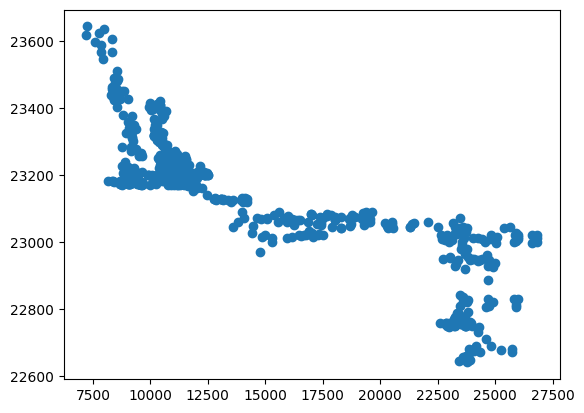

In [26]:
plt.scatter(x=train_MBB,y= train_USD )
plt.show()

In [27]:
corr= train_MBB.corr(train_USD)
corr

-0.8556926316198687

In [28]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(endog=train_MBB,exog=train_USD,order=(0,1,0)).fit()

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
start_test = len(train_MBB)
end_test = len(train_MBB) + len(test_MBB) - 1
pred=model.predict(start=start_test,end=end_test,exog=test_USD,typ='levels')
pred

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


751     23632.388530
752     23724.747485
753     23720.951912
754     23733.603823
755     23809.515293
            ...     
1068    22854.295967
1069    22854.295967
1070    22797.362365
1071    22772.058542
1072    22764.467395
Name: predicted_mean, Length: 322, dtype: float64

In [30]:
pred.index=test_MBB.index

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


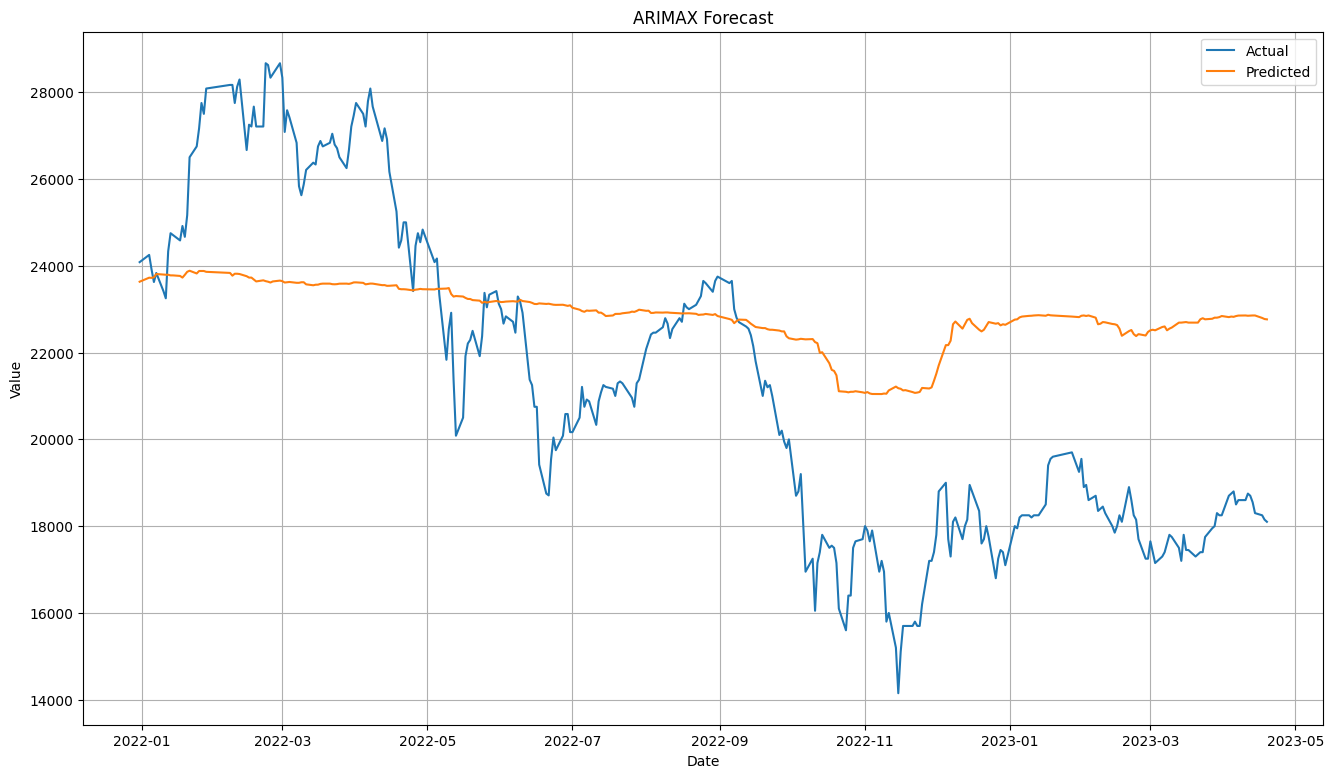

In [31]:
forecast = model.forecast(len(test_MBB),exog=test_USD)
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.plot(test_MBB.index, test_MBB.values, label='Actual')
plt.plot(test_MBB.index, forecast, label='Predicted')
plt.title('ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [32]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

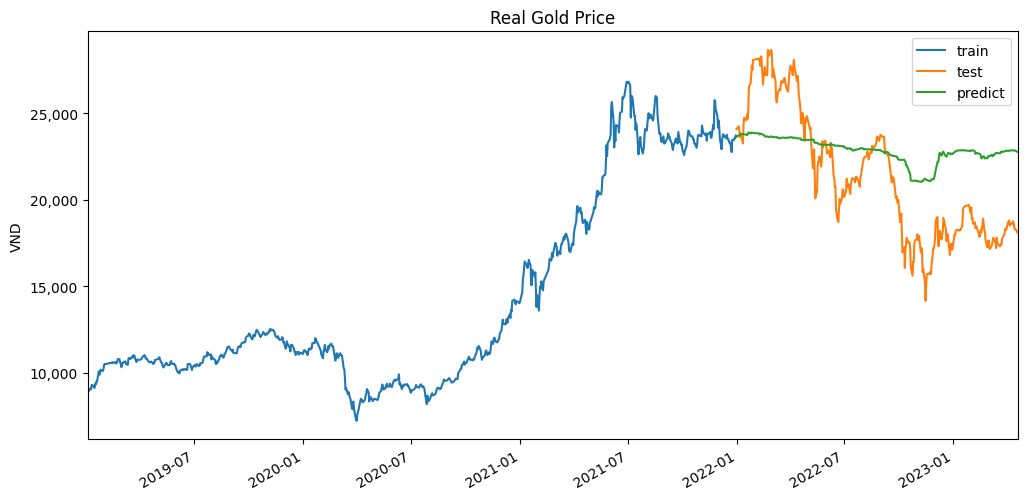

In [33]:
# Plot predictions against known values
title = 'Real Gold Price'
ylabel='VND'
xlabel='' # we don't really need a label here
pd= train_MBB.plot(legend=True,label='train')
ax = test_MBB.plot(legend=True,figsize=(12,6),title=title,label='test')
pred.plot(legend=True,label='predict')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [34]:
mae= mean_absolute_error(test_MBB, pred)
mape = mean_absolute_percentage_error(test_MBB, pred)
mse = mean_squared_error(test_MBB, pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 3036.25
MAPE: 15.55%
MSE: 12281106.72
RMSE: 3504.44
